In [20]:
import os 
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
from matplotlib.ticker import ScalarFormatter
import datetime

%config InlineBackend.figure_formats = ['svg']

# Referential clusters

In [21]:
IQdata_single_0 = np.load("./characterization/rabi12/qubit109/data/IQ_data_state0_single.pkl", allow_pickle=True)
IQdata_single_1 = np.load("./characterization/rabi12/qubit109/data/IQ_data_state1_single.pkl", allow_pickle=True)
IQdata_single_2 = np.load("./characterization/rabi12/qubit109/data/IQ_data_state2_single.pkl", allow_pickle=True)

IQ_data_ref = [IQdata_single_0[0][::4], IQdata_single_1[0][::4], IQdata_single_2[0][::2]]

In [22]:
len(IQ_data_ref[2]), len(IQ_data_ref[0])

(8192, 8192)

### Post-selection $|0\rangle, |1\rangle, |2\rangle$ IQ data

In [23]:
IQdata_0_post_selected = []
IQdata_0_post_rejected = []
rejected_indices = []

for idx, IQpoint in enumerate(IQ_data_ref[0]):
    if np.real(IQpoint) < 0:
        IQdata_0_post_selected.append(IQpoint)
    else:
        rejected_indices.append(idx)
        IQdata_0_post_rejected.append(IQpoint)

IQdata_1_post_selected = []
IQdata_1_post_rejected = []
rejected_indices = []

for idx, IQpoint in enumerate(IQ_data_ref[1]):
    if np.real(IQpoint) > 0:
        IQdata_1_post_selected.append(IQpoint)
    else:
        rejected_indices.append(idx)
        IQdata_1_post_rejected.append(IQpoint)

IQdata_2_post_selected = []
IQdata_2_post_rejected = []
rejected_indices = []

for idx, IQpoint in enumerate(IQ_data_ref[2]):
    if ((np.real(IQpoint)-x0)**2 + (np.imag(IQpoint)-y0)**2) < r**2:
        IQdata_2_post_selected.append(IQpoint)
    else:
        rejected_indices.append(idx)
        IQdata_2_post_rejected.append(IQpoint)

### Post-selected IQ diagram

### Find radius

In [24]:
from scipy.stats import norm

mu0, std0 = norm.fit(np.real(IQ_data_ref[0]))
mu0_ps, std0_ps = norm.fit(np.real(IQdata_0_post_selected))

mu1, std1 = norm.fit(np.real(IQ_data_ref[2]))
mu1_ps, std1_ps = norm.fit(np.real(IQdata_1_post_selected))

mu2, std2 = norm.fit(np.real(IQ_data_ref[2]))
mu2_ps, std2_ps = norm.fit(np.real(IQdata_2_post_selected))

x = np.linspace(-100, 100, 100)

p1 = norm.pdf(x, mu1, std1)
p1_ps = norm.pdf(x, mu1_ps, std1_ps)
p0 = norm.pdf(x, mu0, std0)
p0_ps = norm.pdf(x, mu0_ps, std0_ps)
p2 = norm.pdf(x, mu2, std2)
p2_ps = norm.pdf(x, mu2_ps, std2_ps)

cluster_0_mean = np.mean(IQdata_0_post_selected)
cluster_1_mean = np.mean(IQdata_1_post_selected)
cluster_2_mean = np.mean(IQdata_2_post_selected)

cluster_0_radius = 1.96*std0_ps
cluster_1_radius = 1.96*std1_ps
cluster_2_radius = 1.96*std2_ps

circle0_0 = plt.Circle((np.real(cluster_0_mean), np.imag(cluster_0_mean)), cluster_0_radius, color='red', alpha=0.4)
circle0_1 = plt.Circle((np.real(cluster_0_mean), np.imag(cluster_0_mean)), cluster_0_radius, color='red', alpha=0.4)
circle0_2 = plt.Circle((np.real(cluster_0_mean), np.imag(cluster_0_mean)), cluster_0_radius, color='red', alpha=0.4)
circle1_0 = plt.Circle((np.real(cluster_1_mean), np.imag(cluster_1_mean)), cluster_1_radius, color='blue', alpha=0.4)
circle1_1 = plt.Circle((np.real(cluster_1_mean), np.imag(cluster_1_mean)), cluster_1_radius, color='blue', alpha=0.4)
circle1_2 = plt.Circle((np.real(cluster_1_mean), np.imag(cluster_1_mean)), cluster_1_radius, color='blue', alpha=0.4)
circle2_0 = plt.Circle((np.real(cluster_2_mean), np.imag(cluster_2_mean)), cluster_2_radius, color='green', alpha=0.4)
circle2_1 = plt.Circle((np.real(cluster_2_mean), np.imag(cluster_2_mean)), cluster_2_radius, color='green', alpha=0.4)
circle2_2 = plt.Circle((np.real(cluster_2_mean), np.imag(cluster_2_mean)), cluster_2_radius, color='green', alpha=0.4)

# Load experiment parameters & data

In [62]:
dur = 160
range_amp = 1.0
IQdata_single = np.load(f"./characterization/rabi12/qubit109/data/batch5_vary_rep_delay/{dur}_-0.1_{range_amp}_rd_0.0002_active_reset.pkl", allow_pickle=True)

num_data_point = 100
amplitudes = np.linspace(-0.1, range_amp, num_data_point)

# The usual Rabi osc.

In [63]:
def closest_index(arr, v):
    # Initialize the closest index and the smallest difference
    closest_idx = -1
    smallest_diff = float('inf')
    
    # Iterate over the array
    for i, value in enumerate(arr):
        # Calculate the absolute difference between the current element and v
        diff = abs(value - v)
        
        # Update the closest index and the smallest difference if needed
        if diff < smallest_diff:
            closest_idx = i
            smallest_diff = diff
            
    return closest_idx

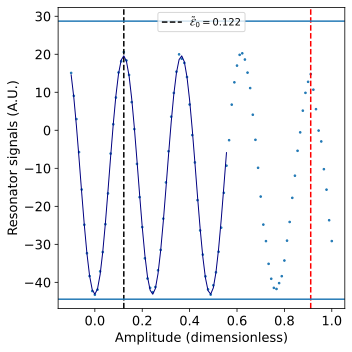

In [64]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

real_avg_IQ = [np.real(np.average(IQdata_single[idx])) for idx in range(num_data_point)]
outliers = 40
popt, yfit, pcov = ut.fit_function(amplitudes[:-outliers], real_avg_IQ[:-outliers], lambda x, A, T, phi, B: (A*np.cos(2*np.pi/T*x+phi)+B), [30, 0.3, 0, 0])
ax.axvline(amplitudes[closest_index(amplitudes,np.round(popt[1]/2,3))], linestyle='--', label=r'$\tilde{\mathcal{E}}_0=$'+f'{np.round(popt[1]/2,3)}', color='black')
ax.axvline(amplitudes[91], linestyle='--', color='red')
ax.plot(amplitudes[:-outliers], yfit, linewidth=1, color='navy')
ax.scatter(amplitudes, real_avg_IQ, s=3)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(fontsize=10, ncol=2)
ax.set_ylabel('Resonator signals (A.U.)', fontsize=13)
ax.set_xlabel('Amplitude (dimensionless)', fontsize=13)
ax.axhline(np.real(cluster_2_mean))
ax.axhline(np.real(cluster_0_mean))
# ax.set_title('Rabi oscillation on $(1-2)$ subspace', fontsize=15)
fig.tight_layout()
# fig.savefig(f'/Users/ngdnhtien/Desktop/rabi{dur}.png', dpi=600)

In [54]:
popt[1]/2

0.1218756008761954

# Plot the variance

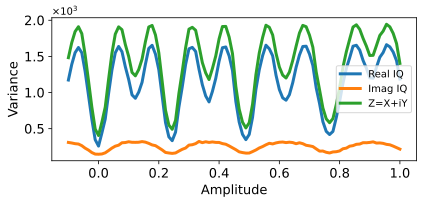

In [55]:
variance_real_list = [np.var(np.real(IQdata_single[idx])) for idx in range(num_data_point)]
variance_imag_list = [np.var(np.imag(IQdata_single[idx])) for idx in range(num_data_point)]
variance_2d_list = [np.var(IQdata_single[idx]) for idx in range(100)]

fig, ax = plt.subplots(ncols=1, figsize=(6,3))

ax.plot(amplitudes, variance_real_list, label='Real IQ', linewidth=3)
ax.plot(amplitudes, variance_imag_list, label='Imag IQ', linewidth=3)
ax.plot(amplitudes, variance_2d_list, label=r'Z=X+iY', linewidth=3)

ax.set_xlabel('Amplitude',fontsize=13)
ax.set_ylabel('Variance',fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend()
fig.tight_layout()
# fig.savefig(f'/Users/ngdnhtien/Desktop/variance{dur}.png', dpi=600)

In [56]:
print(np.argmin(variance_imag_list), np.argmin(variance_real_list), np.argmin(variance_2d_list))

9 9 9


# The selected histogram

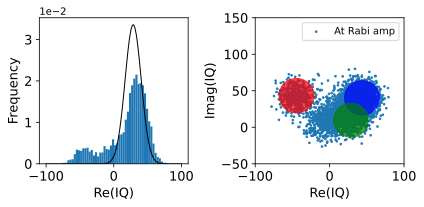

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6,3))

# idx_selected = 9
idx_selected = closest_index(amplitudes,popt[1]/2)

ax1.hist(np.real(IQdata_single[idx_selected]), density=True, bins=50)
ax1.plot(x, p2_ps, 'k', linewidth=1, label='Previous exp.')
ax1.set_xlabel('Re(IQ)',fontsize=13)
ax1.set_ylabel('Frequency', fontsize=13)

ax2.scatter(np.real(IQdata_single[idx_selected]), np.imag(IQdata_single[idx_selected]), s=3, label='At Rabi amp')
ax2.set_xlabel('Re(IQ)',fontsize=13)
ax2.set_ylabel('Imag(IQ)',fontsize=13)
ax2.set_xlim([-100, 100])
ax2.set_xlim([-100, 100])
ax2.set_ylim([-50, 150])

circle0 = plt.Circle((np.real(cluster_0_mean), np.imag(cluster_0_mean)), cluster_0_radius, color='red', alpha=0.7)
circle1 = plt.Circle((np.real(cluster_1_mean), np.imag(cluster_1_mean)), cluster_1_radius, color='blue', alpha=0.7)
circle2 = plt.Circle((np.real(cluster_2_mean), np.imag(cluster_2_mean)), cluster_2_radius, color='green', alpha=0.7)

ax2.add_patch(circle0)
ax2.add_patch(circle1)
ax2.add_patch(circle2)

# IQdata_2_post_selected = []
# IQdata_2_post_rejected = []
# rejected_indices = []

# for idx, IQpoint in enumerate(IQdata_single[idx_selected]):
#     if ((np.real(IQpoint)-x0)**2 + (np.imag(IQpoint)-y0)**2) < r**2:
#         IQdata_2_post_selected.append(IQpoint)
#     else:
#         rejected_indices.append(idx)
#         IQdata_2_post_rejected.append(IQpoint)

# ax2.scatter(np.real(IQdata_2_post_rejected), np.imag(IQdata_2_post_rejected), s=3, label=f'RR {np.round(len(IQdata_2_post_rejected)/len(IQdata_single[idx_selected]),5)}')

ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=13)

ax2.legend()

fig.tight_layout()
# fig.savefig(f'/Users/ngdnhtien/Desktop/hist{dur}.png', dpi=600)

In [66]:
x0, y0

(30, 8)